In [1]:
import sllm2
import torch
from torch import nn
from plotly import express as ex

In [2]:
with open("../simple-llm2/cache.txt") as f:
    db = f.read()

In [3]:
vocab = sorted(set(db))
vocab_size = vsz = len(vocab)
tokenizer = sllm2.tokenizer.Tokenizer()
tokenizer.train(vocab)

In [4]:
tokenizer.decode([0,1,2,3])

['\n', ' ', '"', '&']

In [5]:
data = torch.tensor(tokenizer.encode(db))
data.shape , data.dtype , data.device

(torch.Size([10000]), torch.int64, device(type='cpu'))

In [6]:
split = int (len(db) * 0.9)
train = data[:split]
test = data[split:]

In [7]:
"".join(tokenizer.decode(test.tolist()))

"s throughout the world.\nIn 1988, Irvine became the first non-American president of World Vision International.\nJim Daly.\ncame from Woodside army camp where he was a YMCA army officer.\nAfter his Army service he joined the Adelaide Y as Extension Secretary under Irvine having responsibility for developing boards, programmes and ensuring the viability of Walkerville, Northern Districts (Kilburn), West Croydon and Elizabeth Branches.\nHe was a senior leader at the first Kangaroo Island Camp and many others in preceding years.\nThey were initially organised initially by Don McCallum, Physical Education Director and in following years by Ross Baxter Glen Powell, Gary Kelly, Dean Manning, Dave Badger, Tim Looker.\nThe Kangaroo Island Camps ran for nearly 40 years.\nDaly's particular interest was in Adventure Camping.\nHe personally led groups of senior leaders on Outward Bound-type expeditions to New Zealand, Tasmania (Cradle Mountain Track, Flinders Ranges and the Grampians).\nDaly went

In [8]:
def get_data(batch_size , window_size = 20 , val = False):
    data = test if val else train
    random_pos = torch.randint(len(data)-window_size, (window_size,))
    x = torch.stack([ data[ i  :i+window_size  ] for i in random_pos ])
    y = torch.stack([ data[ i+1:i+window_size+1] for i in random_pos ])
    return x,y

x,y = get_data(batch_size=4, val=True)
print("\r"+"".join(tokenizer.decode(x[0].tolist())), end="")

m Looker.
The Kangar

In [9]:
from dataclasses import dataclass

@dataclass
class ModelArg:
    vocab_size: int = -1
    emb_size: int = 32
    head_size: int = 32
    window_size: int = 20
    lr: float  = 1e-3
    batch_size: int = 32


In [10]:
class Head(nn.Module):
    pass

In [43]:
model_args = ModelArg(
    vocab_size = vocab_size,
    emb_size = vocab_size,
    batch_size= 4,
    head_size= -1,
    window_size=20
)

class Transformer(nn.Module):
    def __init__(self , arg: ModelArg):
        super().__init__()
        self.arg = arg
        self.embedding = nn.Embedding(arg.vocab_size , arg.emb_size) # -> (batch , token , emb)
    
    def forward(self,x : torch.Tensor) -> torch.Tensor:
        b , t = x.shape
        logits = self.embedding(x)
        logits = nn.functional.softmax(logits, dim=-1)
        return logits
    
    def trainer(self, x , y):
        logits = self(x)
        b , t , c = logits.shape
        # print(logits.shape, y.shape)
        loss = nn.functional.cross_entropy(logits.view(b*t,c) , y.view(b*t))
        return logits , loss

net = Transformer(model_args)
x,y = get_data(model_args.batch_size, model_args.window_size)
logits = net(x)

In [12]:
logits.shape

torch.Size([20, 20, 75])

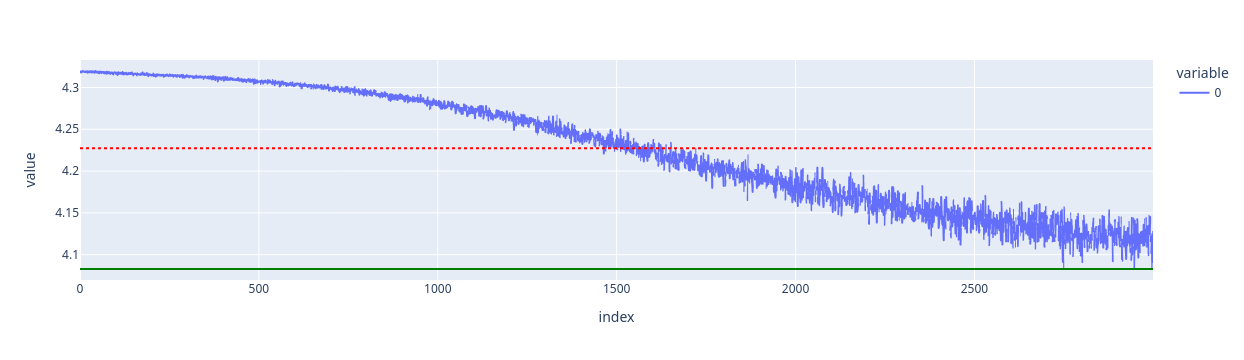

In [44]:
"  ---- traning loop ---- "
net.train()
epoch = 3000
lr = 1e-3
loss_ = []
optim = torch.optim.Adam(params=net.parameters(), lr=lr)
for i in range(epoch):
    data = get_data(model_args.batch_size,model_args.window_size)
    [ logits , loss ] = net.trainer(*data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    loss_.append(loss.item())
    
ex.line(loss_).add_hline( min(loss_),line_color="green").add_hline( sum(loss_)/epoch,line_dash="dot", line_color="red" )

In [46]:
" ---- generate text ---- "
net.eval()
sequence_length = 400
x,_ = get_data(batch_size=1 , window_size=200)
print("prompt: -----------\n","".join(tokenizer.decode(x[0].tolist())),"\nmodel:  ----------\n", sep="\n")
with torch.no_grad():
    for _ in range(sequence_length):
        logits = net(x[:,-net.arg.window_size:])
        predict = torch.multinomial(logits[:,-1,:],num_samples = 1)
        x = torch.concat((x,predict) , -1)
        print(tokenizer.decode(predict[0].tolist())[0], end="" , flush=True)

prompt: -----------

 with the Adelaide YMCA Board while Alf was in India.
He oversaw the expansion of the YMCA and the sale of the Gawler Place building.
In 1956 he negotiated the purchase of the Presbyterian Church in F

model:  ----------

O£&n ore w6Flin alin avyPfj£GB
H3, on t as win tingle wore are athIn wathe wora tirating he tintis t ating anine as at a aus tin tins ti at A tinin tinin ain as tingin ameld ating atin tin araxg on A aB"
£y atis on 19.
The athe 6in atin atin ave atind as A a as atborg worof war tin are atheratin tin aPbati.
HPore walin tin Pr&R's an ating win 56Batin tin aJus atiner a d tid athe atine₤6.£g A in an